In [38]:
%matplotlib inline

import pandas
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

**[2]** Let's load dataset into pandas dataframe and plot data to see what we are dealing with 

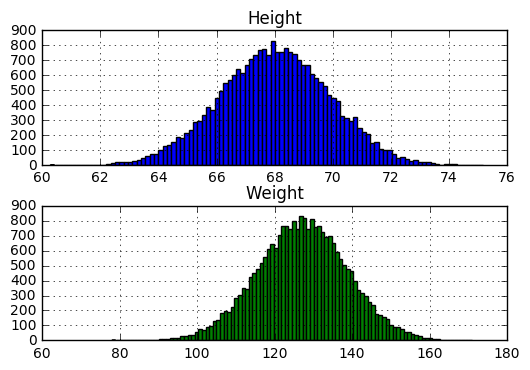

In [5]:
BINS = 100
COLORS = ['b', 'g']

df = pandas.read_csv('data.csv')
#Delete Index column since pandas will provide its own index
del df['Index']

#Some usefull constans
weight_column_index = 'Weight'
height_column_index = 'Height'

#Throw error if num of colors and columns differ
assert(len(COLORS) == len(df.columns))

fig, axes = plt.subplots(len(df.columns), squeeze=False)
for col, axis, c in zip(df.columns, axes, COLORS):
    df.hist(column = col, bins = BINS, ax=axis, color=c, label='HALLO')


**[3]** Now let's add another feature: [BMI](https://en.wikipedia.org/wiki/Body_mass_index), and see how it is dependent on height and weight

In [6]:
# Since our data in inches and pounds we must apply conversion factor
IBM_column = np.multiply(np.divide(df[weight_column_index], np.power(df[height_column_index],2)), 703)
df.assign(IBM=IBM_column)
IBM_column_index = "IBM"

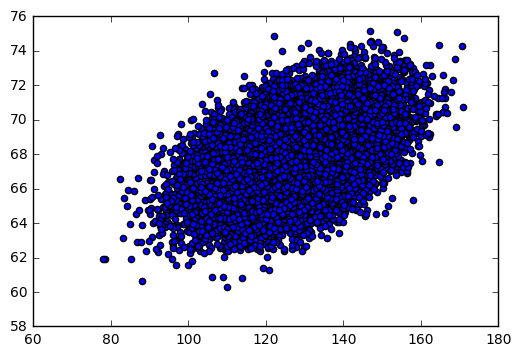

In [7]:
plt.figure()
plt.scatter(x=df[weight_column_index], y=df[height_column_index])
plt.show()

**[4]** After we calculated `BMI` let's categorize weitgh in three categories:
+ 1 - lower than 120 pounds
+ 3 - greater or equal 150 pounds
+ 2 - everything else

In [10]:

# Categorize data according with requirements
def categorize(row):
    if row[weight_column_index] < 120: return 1
    elif row[weight_column_index] >= 150: return 3
    else: return 2

category_weight_column_index = 'Weight_Category'
# Add new column to dataframe as category type    
df[category_weight_column_index] = df.apply(categorize, axis=1).astype('category')

And plot it boxplot of `Height` against `Weight_Category`

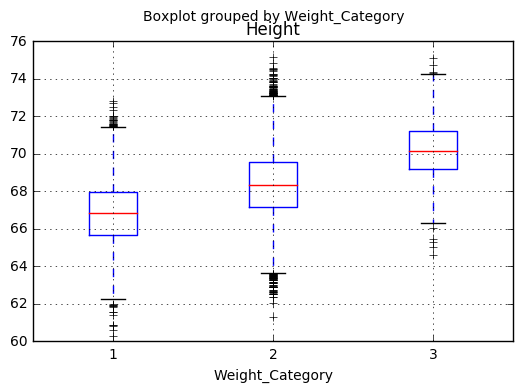

In [14]:
df.boxplot(column=height_column_index, by=category_weight_column_index)

**[5]** In addition let's plot scatterplot of height against weight.

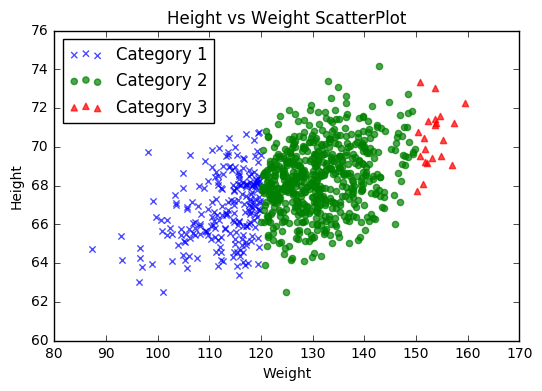

In [84]:
# Change it to sample each `skip_points`
skip_points = 30

plt.figure()
# We will plot data by category on one plot
plt.scatter(x=df[weight_column_index][df[category_weight_column_index] == 1][::skip_points],
            y=df[height_column_index][df[category_weight_column_index] == 1][::skip_points],
            marker = 'x',
            color = 'b',
            label = 'Category 1',
            alpha = 0.7
           )

plt.scatter(x=df[weight_column_index][df[category_weight_column_index] == 2][::skip_points],
            y=df[height_column_index][df[category_weight_column_index] == 2][::skip_points],
            marker = 'o',
            color = 'g',
            label = 'Category 2',
            alpha = 0.7
           )

plt.scatter(x=df[weight_column_index][df[category_weight_column_index] == 3][::skip_points],
            y=df[height_column_index][df[category_weight_column_index] == 3][::skip_points],
            marker = '^',
            color = 'r',
            label = 'Category 3',
            alpha = 0.7
           )

plt.legend(loc='upper left')
plt.title('Height vs Weight ScatterPlot')
plt.ylabel('Height')
plt.xlabel('Weight')

plt.show()

Well, this is definitely not good! We have so many data points that they overlap each other resulting in big colorful blob which doesn't tell us much. Sampling less points doesn't does the trick, additionaly we mihght lose data. Perhaps heatmap will better suit our neads.

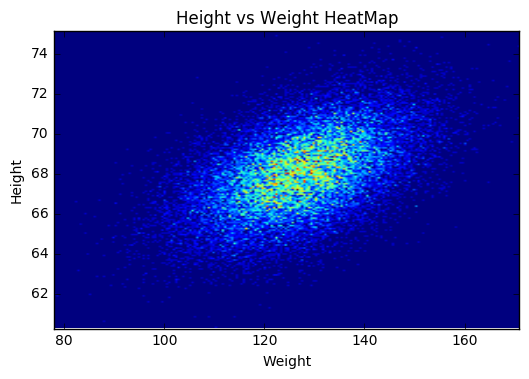

In [75]:
# Number of bins used to split data
bins = 200

heatmap, xedges, yedges = np.histogram2d(df[weight_column_index], df[height_column_index], bins=bins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect=4)
plt.title('Height vs Weight HeatMap')
plt.ylabel('Height')
plt.xlabel('Weight')
plt.show()

**[6]** Now let's try to fit data to polynomial. We will be trying first order polynomial. But first of all we define cost function

In [119]:
def polynomial(w0, w1, weight):
    return np.add(w0, np.multiply(w1, weight))

def error(w0, w1, height, weight):
    return np.sum(np.power(np.subtract(height, np.add(w0, np.multiply(weight, w1))),2))

**[7]** Then we plot two polynomials with weights `(55,0.04)` and `(50,0.22)` on scatter plot from **[5]**

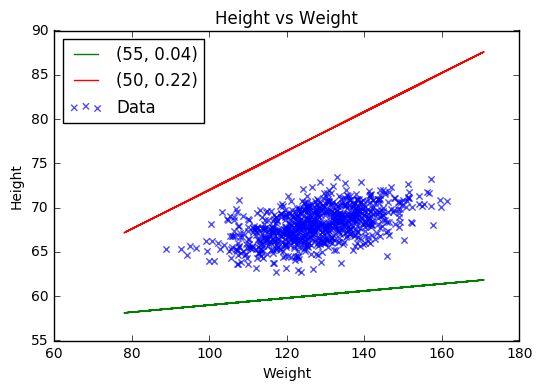

In [129]:
# Change it to sample each `skip_points`
skip_points = 30

plt.figure()

plt.scatter(x=df[weight_column_index][::skip_points],
            y=df[height_column_index][::skip_points],
            marker = 'x',
            color = 'b',
            alpha = 0.7,
            label = 'Data'
           )

# First polynomial
w0_0 = 55
w1_0 = 0.04
plt.plot(df[weight_column_index], polynomial(w0_0, w1_0, df[weight_column_index]), label=(w0_0,w1_0), color='green')

# Second polynomial
w0_1 = 50
w1_1 = 0.22
plt.plot(df[weight_column_index], polynomial(w0_1, w1_1, df[weight_column_index]), label=(w0_1,w1_1), color='red')

plt.title('Height vs Weight')
plt.ylabel('Height')
plt.xlabel('Weight')
plt.legend(loc='upper left')

plt.show()